In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, make_scorer
import xgboost as xgb


In [ ]:
df = pd.read_csv('data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3180 entries, 0 to 3179
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Switch ID                      3180 non-null   object
 1   Port Number                    3180 non-null   object
 2   Received Packets               3180 non-null   int64 
 3   Received Bytes                 3180 non-null   int64 
 4   Sent Bytes                     3180 non-null   int64 
 5   Sent Packets                   3180 non-null   int64 
 6   Port alive Duration (S)        3180 non-null   int64 
 7   Delta Received Packets         3180 non-null   int64 
 8   Delta Received Bytes           3180 non-null   int64 
 9   Delta Sent Bytes               3180 non-null   int64 
 10  Delta Sent Packets             3180 non-null   int64 
 11  Delta Port alive Duration (S)  3180 non-null   int64 
 12  Connection Point               3180 non-null   int64 
 13  Tot

In [ ]:
df.head(10)

,Switch ID,Port Number,Received Packets,Received Bytes,Sent Bytes,Sent Packets,Port alive Duration (S),Delta Received Packets,Delta Received Bytes,Delta Sent Bytes,...,Connection Point,Total Load/Rate,Total Load/Latest,Unknown Load/Rate,Unknown Load/Latest,Latest bytes counter,Active Flow Entries,Packets Looked Up,Packets Matched,Label
0,of:0000000000000004,Port#:1,240,16586,12622603,467,126,0,0,280,...,1,0,0,0,0,0,4,819,757,TCP-SYN
1,of:0000000000000004,Port#:2,158,20530,35464,376,171,4,556,3407,...,2,0,0,0,0,0,5,1018,918,TCP-SYN
2,of:0000000000000008,Port#:3,1930,37881404,67857371,414333,1297,0,0,556,...,2,0,0,0,0,0,8,987400,987276,Normal
3,of:0000000000000001,Port#:4,903,18946410,17900326,98088,176,3,320,270280,...,3,0,0,0,0,0,8,195879,195780,PortScan
4,of:000000000000000b,Port#:1,423,29020,19138042,1562,1451,0,0,560,...,1,0,0,0,0,0,4,4524,4411,Overflow
5,of:000000000000000c,Port#:1,468,32234,42399682,408529,1097,0,0,560,...,1,0,0,0,0,0,4,645351,645228,Normal
6,of:0000000000000003,Port#:2,134,18714,19008,141,161,2,278,278,...,1,0,0,0,0,0,7,3269,3159,TCP-SYN
7,of:0000000000000004,Port#:3,5060,82203513,12769997,1678,1602,4,556,556,...,4,0,0,0,0,0,4,13477,13256,Diversion
8,of:0000000000000004,Port#:3,252,6313946,18440,192,71,2,278,278,...,1,0,0,0,0,0,6,880,774,TCP-SYN
9,of:0000000000000008,Port#:1,1058,18960201,34004,311,236,4,560,556,...,3,0,0,0,0,0,4,2846,2732,PortScan


In [ ]:
df['Port Number'].values

array(['Port#:1', 'Port#:2', 'Port#:3', ..., 'Port#:2', 'Port#:2',
       'Port#:2'], dtype=object)

Getting the Number of Ports to be a Number Not an object

In [ ]:
port = pd.DataFrame(data=df, columns=['Port Number'])
result = port['Port Number'].str.extract('([a-zA-Z-#-:]+)([^a-zA-Z]+)', expand=True)
result.columns = ['Text', 'Number_of_port']
result = result.astype({'Number_of_port':'int'})
df['Number_of_port'] = result.Number_of_port

In [ ]:
df.drop('Port Number',inplace=True,axis=1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3180 entries, 0 to 3179
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Switch ID                      3180 non-null   object
 1   Received Packets               3180 non-null   int64 
 2   Received Bytes                 3180 non-null   int64 
 3   Sent Bytes                     3180 non-null   int64 
 4   Sent Packets                   3180 non-null   int64 
 5   Port alive Duration (S)        3180 non-null   int64 
 6   Delta Received Packets         3180 non-null   int64 
 7   Delta Received Bytes           3180 non-null   int64 
 8   Delta Sent Bytes               3180 non-null   int64 
 9   Delta Sent Packets             3180 non-null   int64 
 10  Delta Port alive Duration (S)  3180 non-null   int64 
 11  Connection Point               3180 non-null   int64 
 12  Total Load/Rate                3180 non-null   int64 
 13  Tot

<ipython-input-190-75b0529c578c>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor = df.corr()


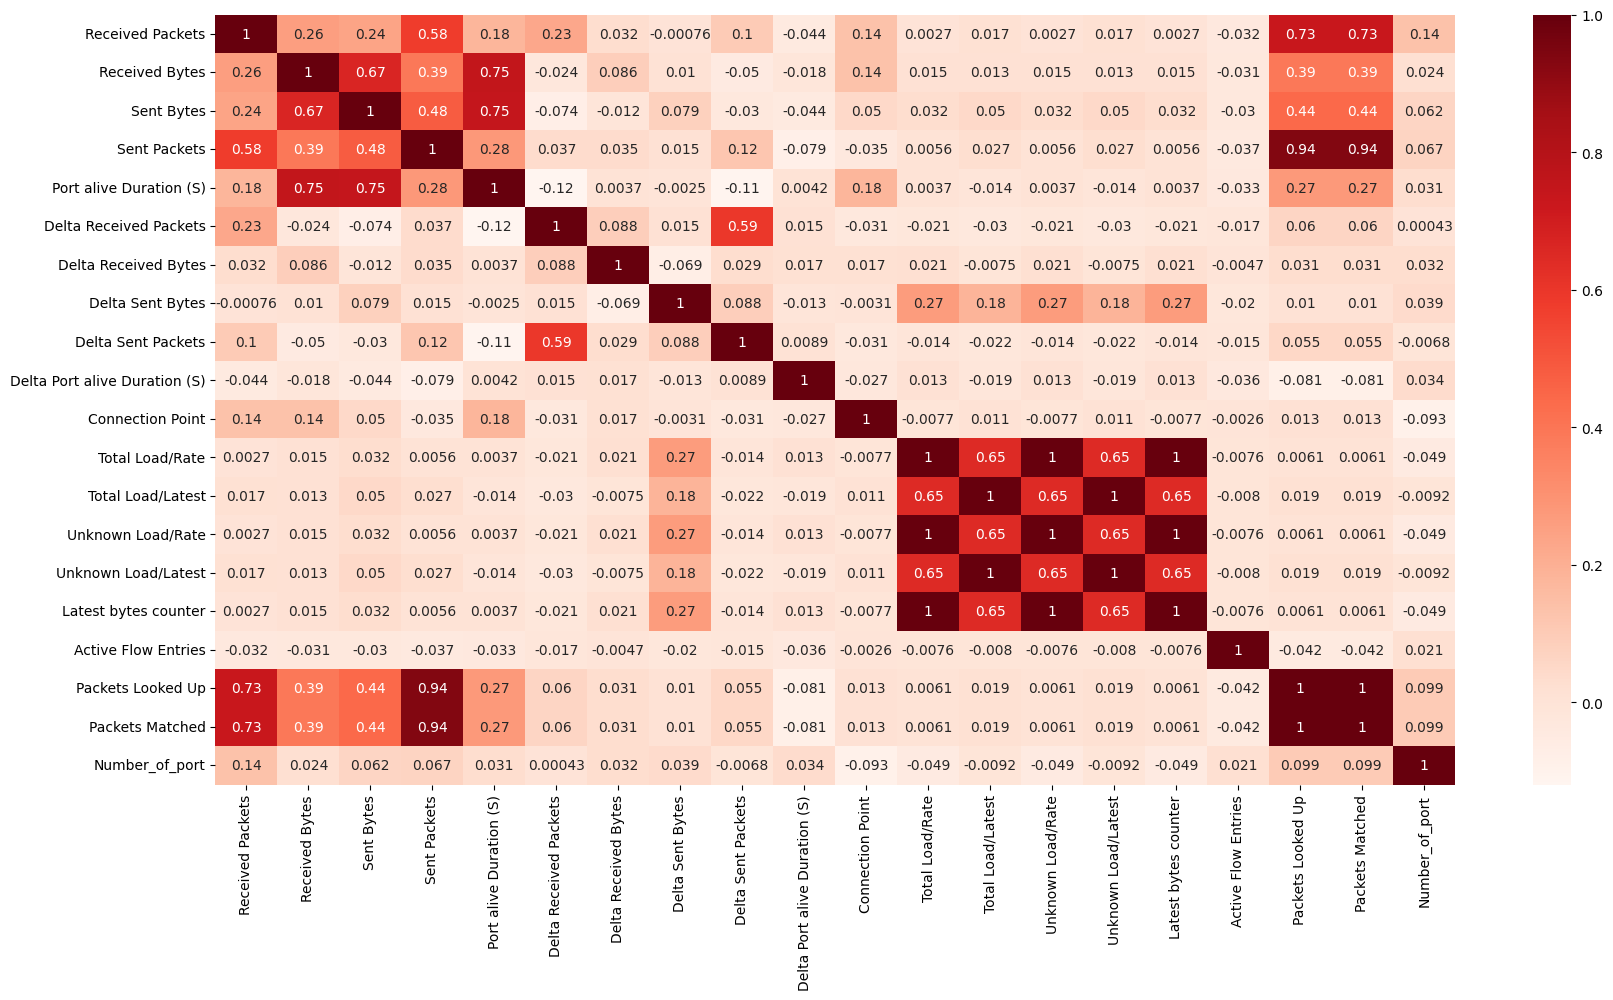

In [ ]:
plt.figure(figsize=(20,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [ ]:
df_clean = df[['Received Packets',
               'Received Bytes',
               'Sent Bytes',
               'Sent Packets',
               'Port alive Duration (S)',
               'Total Load/Rate',
               'Total Load/Latest',
               'Unknown Load/Rate',
               'Unknown Load/Latest',
               'Latest bytes counter',
               'Packets Looked Up',
               'Packets Matched',
               'Label']]

In [ ]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3180 entries, 0 to 3179
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Received Packets         3180 non-null   int64 
 1   Received Bytes           3180 non-null   int64 
 2   Sent Bytes               3180 non-null   int64 
 3   Sent Packets             3180 non-null   int64 
 4   Port alive Duration (S)  3180 non-null   int64 
 5   Total Load/Rate          3180 non-null   int64 
 6   Total Load/Latest        3180 non-null   int64 
 7   Unknown Load/Rate        3180 non-null   int64 
 8   Unknown Load/Latest      3180 non-null   int64 
 9   Latest bytes counter     3180 non-null   int64 
 10  Packets Looked Up        3180 non-null   int64 
 11  Packets Matched          3180 non-null   int64 
 12  Label                    3180 non-null   object
dtypes: int64(12), object(1)
memory usage: 323.1+ KB


<ipython-input-193-974b79fb2a6c>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor = df_clean.corr()


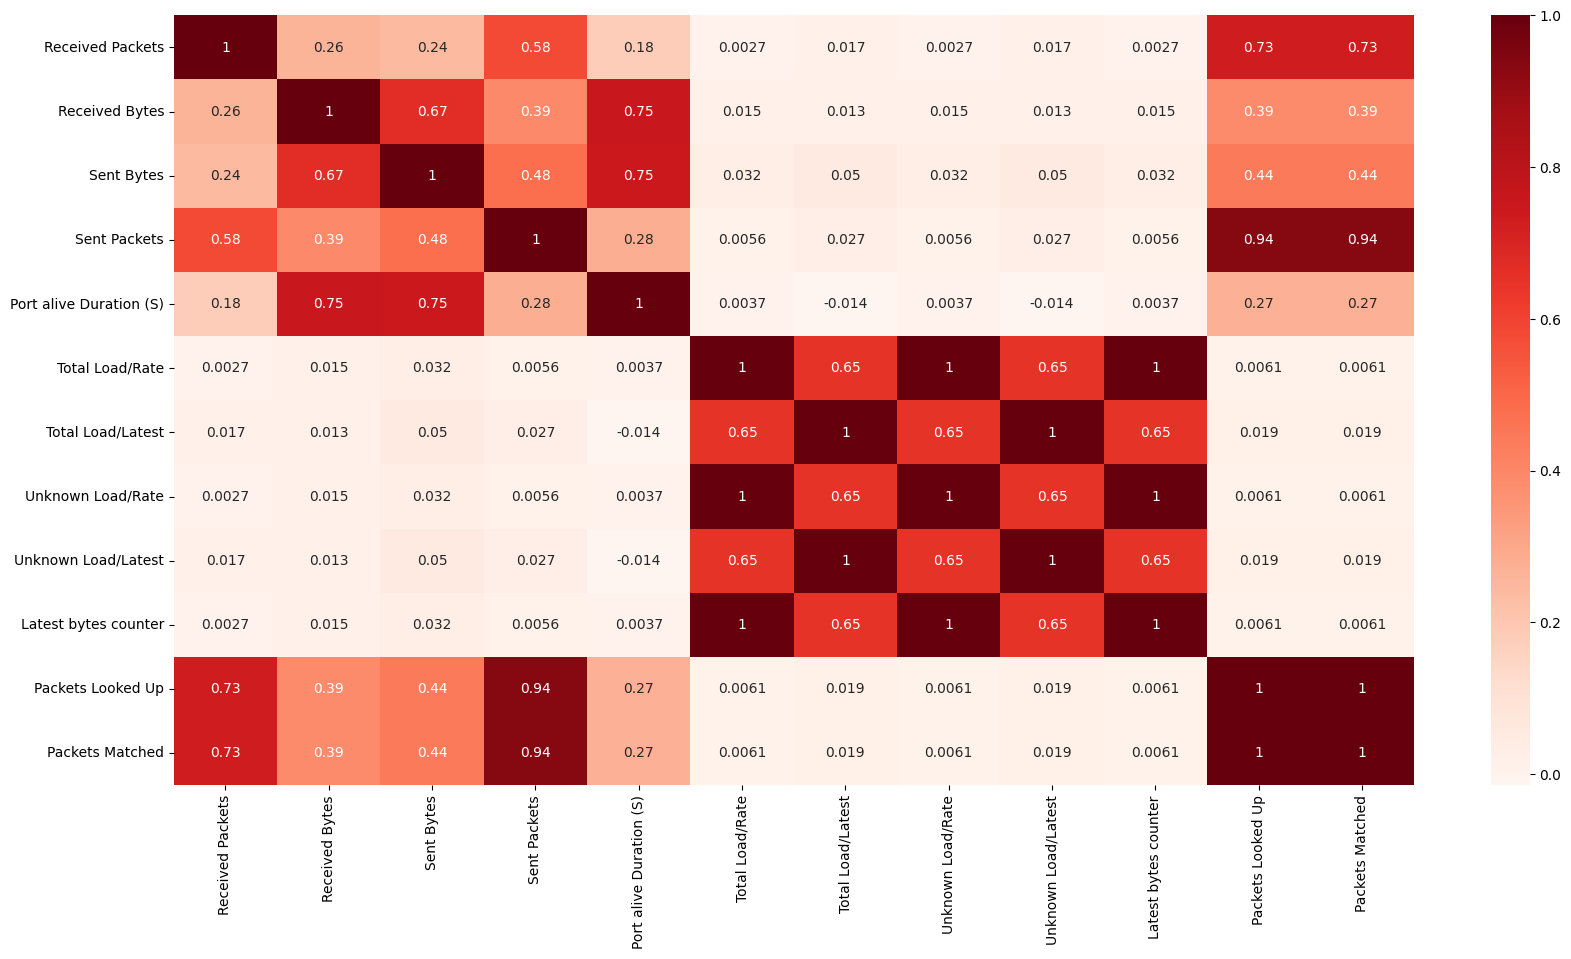

In [ ]:
plt.figure(figsize=(20,10))
cor = df_clean.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [ ]:
df_clean

,Received Packets,Received Bytes,Sent Bytes,Sent Packets,Port alive Duration (S),Total Load/Rate,Total Load/Latest,Unknown Load/Rate,Unknown Load/Latest,Latest bytes counter,Packets Looked Up,Packets Matched,Label
0,240,16586,12622603,467,126,0,0,0,0,0,819,757,TCP-SYN
1,158,20530,35464,376,171,0,0,0,0,0,1018,918,TCP-SYN
2,1930,37881404,67857371,414333,1297,0,0,0,0,0,987400,987276,Normal
3,903,18946410,17900326,98088,176,0,0,0,0,0,195879,195780,PortScan
4,423,29020,19138042,1562,1451,0,0,0,0,0,4524,4411,Overflow
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3175,133,9251,6317978,286,106,0,0,0,0,0,1718,1631,TCP-SYN
3176,1216,31540813,36309076,413180,1037,0,0,0,0,0,983638,983516,Normal
3177,1736,19039951,6408719,1005,1071,0,0,0,0,0,6950,6779,Diversion
3178,187954,52149755,55635486,121662,2560,0,0,0,0,0,519051,518963,Normal


In [ ]:
df_clean.describe()

,Received Packets,Received Bytes,Sent Bytes,Sent Packets,Port alive Duration (S),Total Load/Rate,Total Load/Latest,Unknown Load/Rate,Unknown Load/Latest,Latest bytes counter,Packets Looked Up,Packets Matched
count,3180.000000,3.180000e+03,3.180000e+03,3180.000000,3180.000000,3.180000e+03,3.180000e+03,3.180000e+03,3.180000e+03,3.180000e+03,3.180000e+03,3.180000e+03
mean,19988.512893,2.614474e+07,2.388422e+07,32376.839623,900.916038,1.921688e+04,4.924701e+05,1.921688e+04,4.924701e+05,1.921688e+04,9.649218e+04,9.637181e+04
std,61326.785779,3.641721e+07,3.329263e+07,88083.703600,972.205171,1.104324e+05,1.783842e+06,1.104324e+05,1.783842e+06,1.104324e+05,2.312447e+05,2.312438e+05
min,10.000000,8.560000e+02,6.025000e+03,44.000000,26.000000,-6.446240e+05,0.000000e+00,-6.446240e+05,0.000000e+00,-6.446240e+05,1.050000e+02,5.000000e+01
25%,338.750000,9.270625e+04,5.264600e+04,342.500000,136.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.291750e+03,2.192000e+03
50%,1175.500000,1.262505e+07,1.262356e+07,1241.500000,261.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.243500e+03,7.135000e+03
75%,3302.750000,3.766792e+07,3.171733e+07,3770.750000,1732.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.125350e+04,2.101850e+04
max,352584.000000,2.652568e+08,2.130728e+08,420806.000000,3317.000000,1.260664e+06,1.275386e+07,1.260664e+06,1.275386e+07,1.260664e+06,1.012220e+06,1.012085e+06


In [ ]:
df_clean.loc[df_clean['Unknown Load/Rate'] == df_clean['Total Load/Rate']].count()

Received Packets           3180
Received Bytes             3180
Sent Bytes                 3180
Sent Packets               3180
Port alive Duration (S)    3180
Total Load/Rate            3180
Total Load/Latest          3180
Unknown Load/Rate          3180
Unknown Load/Latest        3180
Latest bytes counter       3180
Packets Looked Up          3180
Packets Matched            3180
Label                      3180
dtype: int64

In [ ]:
df_clean.loc[df_clean['Unknown Load/Rate'] == df_clean['Latest bytes counter']].count()

Received Packets           3180
Received Bytes             3180
Sent Bytes                 3180
Sent Packets               3180
Port alive Duration (S)    3180
Total Load/Rate            3180
Total Load/Latest          3180
Unknown Load/Rate          3180
Unknown Load/Latest        3180
Latest bytes counter       3180
Packets Looked Up          3180
Packets Matched            3180
Label                      3180
dtype: int64

In [ ]:
df_clean.drop(columns=['Latest bytes counter','Unknown Load/Latest','Unknown Load/Rate'],inplace=True,axis=1)

<ipython-input-198-81fe779c02d3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.drop(columns=['Latest bytes counter','Unknown Load/Latest','Unknown Load/Rate'],inplace=True,axis=1)


In [ ]:
df_clean

,Received Packets,Received Bytes,Sent Bytes,Sent Packets,Port alive Duration (S),Total Load/Rate,Total Load/Latest,Packets Looked Up,Packets Matched,Label
0,240,16586,12622603,467,126,0,0,819,757,TCP-SYN
1,158,20530,35464,376,171,0,0,1018,918,TCP-SYN
2,1930,37881404,67857371,414333,1297,0,0,987400,987276,Normal
3,903,18946410,17900326,98088,176,0,0,195879,195780,PortScan
4,423,29020,19138042,1562,1451,0,0,4524,4411,Overflow
...,...,...,...,...,...,...,...,...,...,...
3175,133,9251,6317978,286,106,0,0,1718,1631,TCP-SYN
3176,1216,31540813,36309076,413180,1037,0,0,983638,983516,Normal
3177,1736,19039951,6408719,1005,1071,0,0,6950,6779,Diversion
3178,187954,52149755,55635486,121662,2560,0,0,519051,518963,Normal


In [ ]:
df_clean.describe()

,Received Packets,Received Bytes,Sent Bytes,Sent Packets,Port alive Duration (S),Total Load/Rate,Total Load/Latest,Packets Looked Up,Packets Matched
count,3180.000000,3.180000e+03,3.180000e+03,3180.000000,3180.000000,3.180000e+03,3.180000e+03,3.180000e+03,3.180000e+03
mean,19988.512893,2.614474e+07,2.388422e+07,32376.839623,900.916038,1.921688e+04,4.924701e+05,9.649218e+04,9.637181e+04
std,61326.785779,3.641721e+07,3.329263e+07,88083.703600,972.205171,1.104324e+05,1.783842e+06,2.312447e+05,2.312438e+05
min,10.000000,8.560000e+02,6.025000e+03,44.000000,26.000000,-6.446240e+05,0.000000e+00,1.050000e+02,5.000000e+01
25%,338.750000,9.270625e+04,5.264600e+04,342.500000,136.000000,0.000000e+00,0.000000e+00,2.291750e+03,2.192000e+03
50%,1175.500000,1.262505e+07,1.262356e+07,1241.500000,261.000000,0.000000e+00,0.000000e+00,7.243500e+03,7.135000e+03
75%,3302.750000,3.766792e+07,3.171733e+07,3770.750000,1732.000000,0.000000e+00,0.000000e+00,2.125350e+04,2.101850e+04
max,352584.000000,2.652568e+08,2.130728e+08,420806.000000,3317.000000,1.260664e+06,1.275386e+07,1.012220e+06,1.012085e+06


<ipython-input-201-974b79fb2a6c>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor = df_clean.corr()


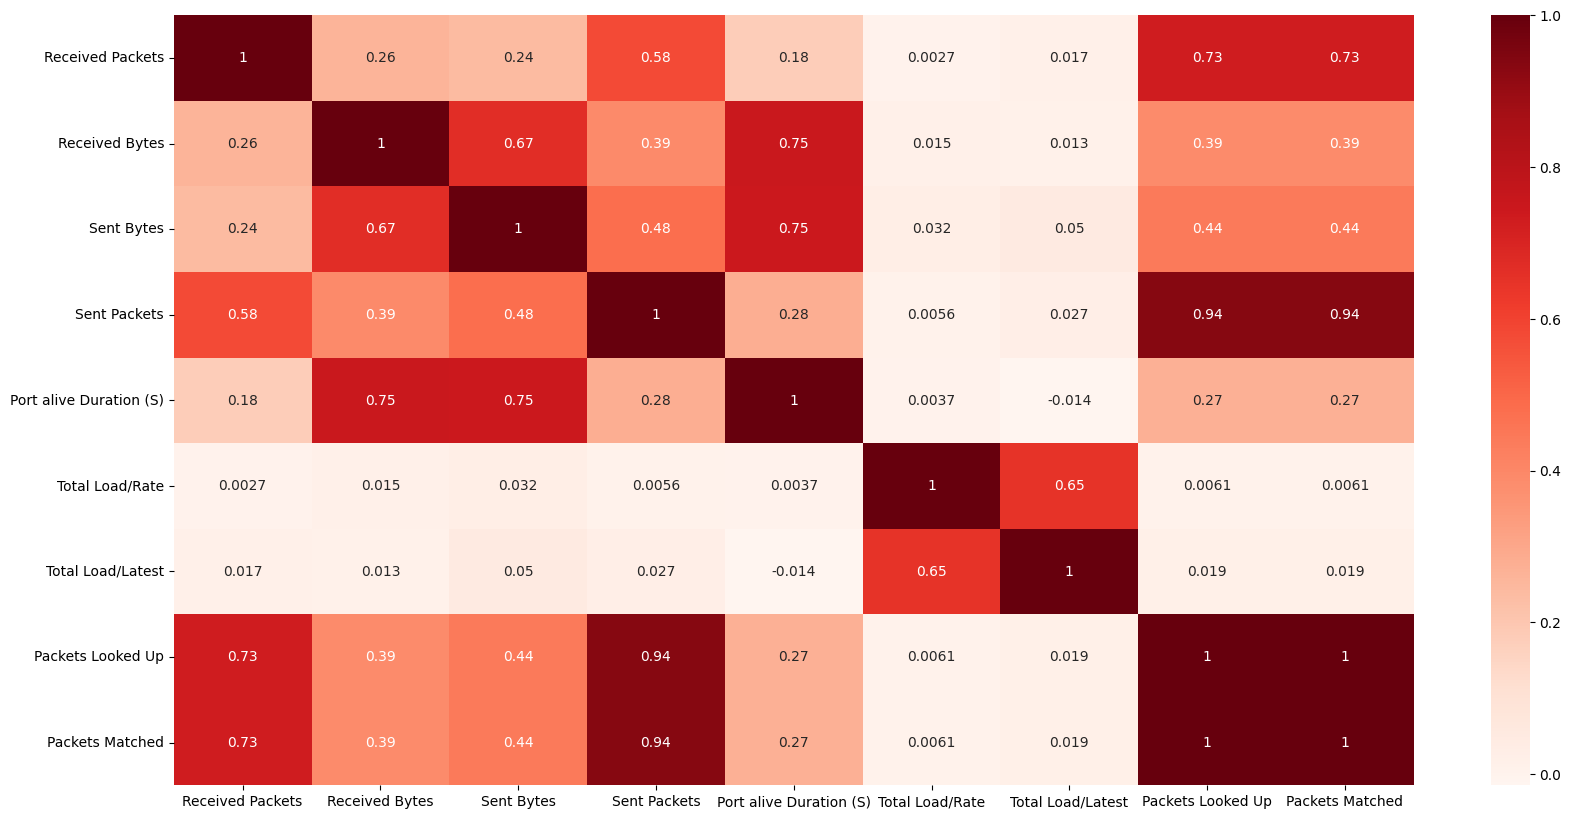

In [ ]:
plt.figure(figsize=(20,10))
cor = df_clean.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [ ]:
df_clean.drop(columns = ['Total Load/Rate','Total Load/Latest'],inplace=True,axis=1)

<ipython-input-202-b8f62ecf93fd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.drop(columns = ['Total Load/Rate','Total Load/Latest'],inplace=True,axis=1)


<ipython-input-203-974b79fb2a6c>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor = df_clean.corr()


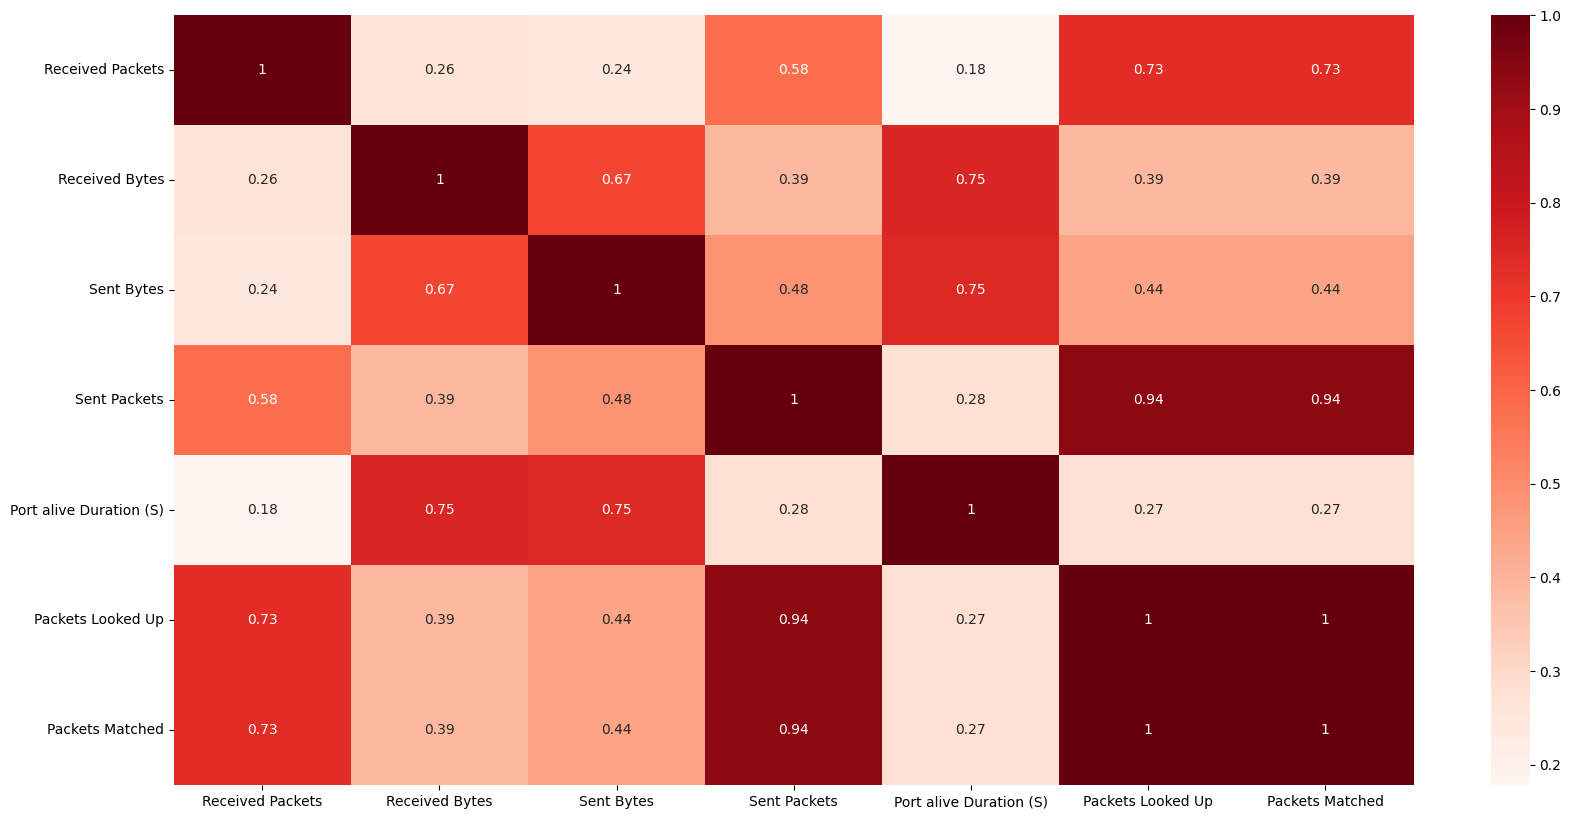

In [ ]:
plt.figure(figsize=(20,10))
cor = df_clean.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [ ]:
df_clean

,Received Packets,Received Bytes,Sent Bytes,Sent Packets,Port alive Duration (S),Packets Looked Up,Packets Matched,Label
0,240,16586,12622603,467,126,819,757,TCP-SYN
1,158,20530,35464,376,171,1018,918,TCP-SYN
2,1930,37881404,67857371,414333,1297,987400,987276,Normal
3,903,18946410,17900326,98088,176,195879,195780,PortScan
4,423,29020,19138042,1562,1451,4524,4411,Overflow
...,...,...,...,...,...,...,...,...
3175,133,9251,6317978,286,106,1718,1631,TCP-SYN
3176,1216,31540813,36309076,413180,1037,983638,983516,Normal
3177,1736,19039951,6408719,1005,1071,6950,6779,Diversion
3178,187954,52149755,55635486,121662,2560,519051,518963,Normal


In [ ]:
df_clean.loc[df_clean['Packets Matched'] > 0].count()

Received Packets           3180
Received Bytes             3180
Sent Bytes                 3180
Sent Packets               3180
Port alive Duration (S)    3180
Packets Looked Up          3180
Packets Matched            3180
Label                      3180
dtype: int64

In [ ]:
column_to_scale = ['Received Packets','Received Bytes','Sent Bytes','Sent Packets','Port alive Duration (S)','Packets Looked Up','Packets Matched']

scaler = StandardScaler()

# Fit the scaler on the selected column and transform it
df_clean[column_to_scale] = scaler.fit_transform(df_clean[column_to_scale])

<ipython-input-211-814db6c447f4>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[column_to_scale] = scaler.fit_transform(df_clean[column_to_scale])


In [ ]:
label_encoder = LabelEncoder()
df_clean['Label'] = label_encoder.fit_transform(df_clean["Label"])

<ipython-input-213-88d5c8499198>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Label'] = label_encoder.fit_transform(df_clean["Label"])


In [ ]:
df_clean.describe()

,Received Packets,Received Bytes,Sent Bytes,Sent Packets,Port alive Duration (S),Packets Looked Up,Packets Matched,Label
count,3.180000e+03,3.180000e+03,3.180000e+03,3.180000e+03,3.180000e+03,3.180000e+03,3.180000e+03,3180.000000
mean,-2.765084e-17,3.575058e-17,6.703233e-18,-1.117206e-18,3.239896e-17,5.586028e-18,-1.787529e-17,2.663522
std,1.000157e+00,1.000157e+00,1.000157e+00,1.000157e+00,1.000157e+00,1.000157e+00,1.000157e+00,1.959320
min,-3.258226e-01,-7.180122e-01,-7.173343e-01,-3.671272e-01,-9.000710e-01,-4.168846e-01,-4.166035e-01,0.000000
25%,-3.204612e-01,-7.154896e-01,-7.159338e-01,-3.637379e-01,-7.869083e-01,-4.074267e-01,-4.073391e-01,1.000000
50%,-3.068149e-01,-3.713031e-01,-3.382860e-01,-3.535301e-01,-6.583144e-01,-3.860098e-01,-3.859600e-01,3.000000
75%,-2.721223e-01,3.164710e-01,2.353177e-01,-3.248114e-01,8.549787e-01,-3.254151e-01,-3.259122e-01,4.000000
max,5.424184e+00,6.566941e+00,5.683489e+00,4.410467e+00,2.485549e+00,3.960618e+00,3.960570e+00,5.000000


[1.0, 0.8867924528301887, 0.8765723270440252, 0.85062893081761, 0.8337264150943396, 0.8278301886792453, 0.8195754716981132, 0.8077830188679245, 0.7955974842767296, 0.7936320754716981, 0.7841981132075472, 0.785377358490566, 0.7818396226415094, 0.7783018867924528, 0.773191823899371, 0.7684748427672956, 0.7688679245283019, 0.7610062893081762, 0.7637578616352201, 0.7617924528301887, 0.7598270440251572, 0.7606132075471698, 0.7539308176100629, 0.7515723270440252]
[0.7704402515723271, 0.7232704402515723, 0.7625786163522013, 0.7610062893081762, 0.7578616352201258, 0.7594339622641509, 0.7610062893081762, 0.7657232704402516, 0.7625786163522013, 0.7562893081761006, 0.7610062893081762, 0.7515723270440252, 0.7468553459119497, 0.75, 0.7452830188679245, 0.7374213836477987, 0.7389937106918238, 0.7358490566037735, 0.7342767295597484, 0.7327044025157232, 0.7405660377358491, 0.7342767295597484, 0.7389937106918238, 0.7264150943396226]


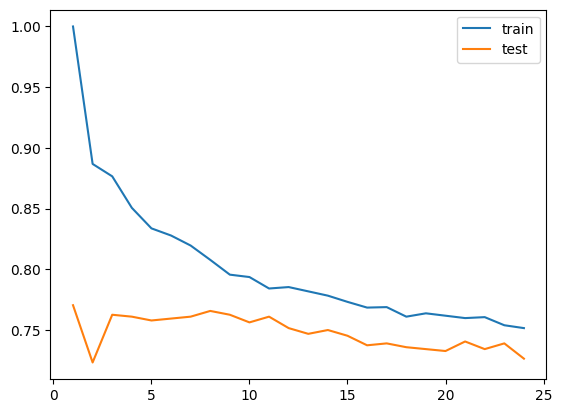

In [ ]:
cols = ['Received Packets','Received Bytes','Sent Bytes','Sent Packets','Port alive Duration (S)','Packets Looked Up','Packets Matched']
x = df_clean[cols]
y = df_clean['Label']

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2, random_state=42,stratify=y)

scores_train=[]
scores_test=[]
neigh = range(1,25)

for n in neigh:
  knn = KNeighborsClassifier(n_neighbors=n)
  knn.fit(x_train,y_train)
  scores_train.append(knn.score(x_train,y_train))
  scores_test.append(knn.score(x_test,y_test))

print(scores_train)
print(scores_test)


plt.plot(neigh, scores_train, label = "train")
plt.plot(neigh, scores_test, label = "test")
plt.legend()
plt.show()

In [ ]:
y

0       5
1       5
2       2
3       4
4       3
       ..
3175    5
3176    2
3177    1
3178    2
3179    1
Name: Label, Length: 3180, dtype: int64

In [ ]:
knn = KNeighborsClassifier(n_neighbors=17)
knn.fit(x_train,y_train)
y_pred_knn = knn.predict(x_test)

In [ ]:
print(confusion_matrix(y_test,y_pred_knn))

print(classification_report(y_test,y_pred_knn))

[[174  50   0   0   3   5]
 [ 54 101   0   0   5   7]
 [  0   0  99   0   0   0]
 [  5   3   0   0   9  12]
 [  1   0   1   1 195  69]
 [  2   0   0   0  44 210]]
              precision    recall  f1-score   support

           0       0.74      0.75      0.74       232
           1       0.66      0.60      0.63       167
           2       0.99      1.00      0.99        99
           3       0.00      0.00      0.00        29
           4       0.76      0.73      0.75       267
           5       0.69      0.82      0.75       256

    accuracy                           0.74      1050
   macro avg       0.64      0.65      0.64      1050
weighted avg       0.72      0.74      0.73      1050



In [ ]:
tree = DecisionTreeClassifier(random_state=42)
tree.fit(x_train,y_train)
y_pred_tree = tree.predict(x_test)

In [ ]:
print(confusion_matrix(y_test,y_pred_tree))

print(classification_report(y_test,y_pred_tree))

[[175  51   0   1   1   4]
 [ 28 125   0   3   7   4]
 [  0   0  99   0   0   0]
 [  1   7   0  10   7   4]
 [  5   3   0   2 202  55]
 [  2   2   0  10  45 197]]
              precision    recall  f1-score   support

           0       0.83      0.75      0.79       232
           1       0.66      0.75      0.70       167
           2       1.00      1.00      1.00        99
           3       0.38      0.34      0.36        29
           4       0.77      0.76      0.76       267
           5       0.75      0.77      0.76       256

    accuracy                           0.77      1050
   macro avg       0.73      0.73      0.73      1050
weighted avg       0.77      0.77      0.77      1050



In [ ]:
rforest = RandomForestClassifier(random_state=42)
rforest.fit(x_train,y_train)
y_pred_rf = rforest.predict(x_test)

In [ ]:
print(confusion_matrix(y_test,y_pred_rf))

print(classification_report(y_test,y_pred_rf))

[[199  26   0   1   1   5]
 [ 33 123   0   1   8   2]
 [  0   0  99   0   0   0]
 [  1   6   0   8   7   7]
 [  0   3   0   1 217  46]
 [  0   1   0   0  34 221]]
              precision    recall  f1-score   support

           0       0.85      0.86      0.86       232
           1       0.77      0.74      0.75       167
           2       1.00      1.00      1.00        99
           3       0.73      0.28      0.40        29
           4       0.81      0.81      0.81       267
           5       0.79      0.86      0.82       256

    accuracy                           0.83      1050
   macro avg       0.83      0.76      0.77      1050
weighted avg       0.82      0.83      0.82      1050



In [ ]:
param_grid = {
   'n_estimators': np.arange(50, 201, 10),
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': np.arange(2, 11),
    'min_samples_leaf': np.arange(1, 5),
    'max_features': ['auto', 'sqrt'],
    'bootstrap': [True, False]
}


macro_avg_f1_scorer = make_scorer(f1_score, average='macro')

random_search = RandomizedSearchCV(
    rforest,
    param_distributions=param_grid,
    n_iter=30,  # Number of parameter settings that are sampled
    scoring=macro_avg_f1_scorer,  # Use macro-average F1 score as the evaluation metric
    cv=5,  # 5-fold cross-validation
    random_state=42,
)

# Fit the RandomizedSearchCV instance to the data
random_search.fit(x_train, y_train)

# Print the best parameters found
print("Best parameters:", random_search.best_params_)
print("Best macro-average F1 score:", random_search.best_score_)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

Best parameters: {'n_estimators': 120, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
Best macro-average F1 score: 0.7544263505706641


Best parameters: {'n_estimators': 120, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
Best macro-average F1 score: 0.7544263505706641

In [ ]:
rforest = RandomForestClassifier(random_state=42,n_estimators=120,min_samples_split=2,min_samples_leaf=1,max_depth=20,bootstrap=False,max_features='auto')
rforest.fit(x_train,y_train)
y_pred_rf = rforest.predict(x_test)
print(confusion_matrix(y_test,y_pred_rf))
print(classification_report(y_test,y_pred_rf))

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[[128   9   0   0   1   3]
 [ 14  78   0   0   7   2]
 [  0   0  60   0   0   0]
 [  0   0   0   6   6   6]
 [  0   1   0   1 130  29]
 [  0   0   0   0  13 142]]
              precision    recall  f1-score   support

           0       0.90      0.91      0.90       141
           1       0.89      0.77      0.83       101
           2       1.00      1.00      1.00        60
           3       0.86      0.33      0.48        18
           4       0.83      0.81      0.82       161
           5       0.78      0.92      0.84       155

    accuracy                           0.86       636
   macro avg       0.88      0.79      0.81       636
weighted avg       0.86      0.86      0.85       636



In [ ]:
xgb_model = xgb.XGBClassifier(objective="multi:softmax", random_state=42,num_class=6,n_estimators=1000)
xgb_model.fit(x_train, y_train)

y_pred_xg = xgb_model.predict(x_test)
print(confusion_matrix(y_test,y_pred_xg))
print(classification_report(y_test,y_pred_xg))

[[122  15   0   0   2   2]
 [ 11  82   0   0   4   4]
 [  0   0  60   0   0   0]
 [  0   0   0   9   5   4]
 [  0   1   0   1 135  24]
 [  0   0   0   0  23 132]]
              precision    recall  f1-score   support

           0       0.92      0.87      0.89       141
           1       0.84      0.81      0.82       101
           2       1.00      1.00      1.00        60
           3       0.90      0.50      0.64        18
           4       0.80      0.84      0.82       161
           5       0.80      0.85      0.82       155

    accuracy                           0.85       636
   macro avg       0.87      0.81      0.83       636
weighted avg       0.85      0.85      0.85       636



In [ ]:
params = {
    'n_estimators': np.arange(50, 201, 10),
    'max_depth': np.arange(3, 11),
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.1, 0.01, 0.001],
    'reg_lambda': [0, 0.1, 0.01, 0.001],
    'min_child_weight': np.arange(1, 11)
}


macro_avg_f1_scorer = make_scorer(f1_score, average='macro')

# Create a RandomizedSearchCV instance
random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=params,
    n_iter=20,  # Number of parameter settings that are sampled
    scoring=macro_avg_f1_scorer,  # Use macro-average F1 score as the evaluation metric
    cv=5,  # 5-fold cross-validation
    random_state=42,
)

random_search.fit(x_train, y_train)

# Print the best parameters found
print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

Best parameters: {'subsample': 1.0, 'reg_lambda': 0.1, 'reg_alpha': 0.1, 'n_estimators': 60, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.3, 'gamma': 0.1, 'colsample_bytree': 0.9}
Best score: 0.7855292083501108


In [ ]:
xgb_model = xgb.XGBClassifier(objective="multi:softmax", random_state=42,num_class=6,n_estimators=60,subsample=1,max_depth=6,reg_lambda=0.1,reg_alpha=0.1,gamma=0.1,colsample_bytree=0.9)
xgb_model.fit(x_train, y_train)

y_pred_xg = xgb_model.predict(x_test)
print(confusion_matrix(y_test,y_pred_xg))
print(classification_report(y_test,y_pred_xg))
print("Best Model Score:", xgb_model.score(x_test, y_test))

[[124  13   0   0   2   2]
 [ 12  81   0   0   5   3]
 [  0   0  60   0   0   0]
 [  0   0   0  10   4   4]
 [  1   0   0   1 129  30]
 [  0   0   0   0  16 139]]
              precision    recall  f1-score   support

           0       0.91      0.88      0.89       141
           1       0.86      0.80      0.83       101
           2       1.00      1.00      1.00        60
           3       0.91      0.56      0.69        18
           4       0.83      0.80      0.81       161
           5       0.78      0.90      0.83       155

    accuracy                           0.85       636
   macro avg       0.88      0.82      0.84       636
weighted avg       0.86      0.85      0.85       636

Best Model Score: 0.8537735849056604
